# <img src="./assets/fd-logo.png" style="width:10%;height=10%"/>
# Case Study: Electric Toothbrushes Production

## Introduction

You have access to the following data:
- Production forecasts for several electric toothbrush manufacturers for current products and planned product launches until December 2025.
- Price data for parts and materials for current and planned electric toothbrushes.
The data is stored in an Excel file with 3 worksheets.

## Data Dictionary

```yaml
file_path: data/production_forecast.xlsx
worksheets:
    - PRODUCTION_FORECAST:
        - COMPANY: Name of the electric toothbrush  manufacturer
        - PRODUCT: Name of electric toothbrush
        - {YYYY}-{MM}: Forecasted (or realised) production in a given month in number of units
        - {YYYY}Q{Q}: Forecasted (or realised) production in a given quarter in number of units
        - {YYYY}CY: Forecasted (or realised) production in a given calendar year in number of units
    - PARTS_SUPPLIERS:
        - PART_TYPE: Type of part
        - COMPANY: Name of part supplier
        - PART: Name of part
        - CUSTOMER: Name of customer
        - CUSTOMER_PRODUCT: Product the part will be used for
        - PRICE_PER_PRODUCT: Price of the parts used to produce one unit of the product
    - MATERIALS_SUPPLIERS:
        - MATERIAL: Name of material
        - COMPANY: Name of material supplier
        - CUSTOMER: Name of customer
        - CUSTOMER_PRODUCT: Product the material will be used for
        - PRICE_PER_PRODUCT: Price of the material used to produce one unit of the product
```

__Note:__ The total cost and materials of parts of one unit of a product is the sum of the `PRICE_PER_PRODUCT` of all the parts and materials supplied for this product.

## Part 1

__Q1.__ Create a class to read and store the data. 

__Q2.__ Add checks to validate that each worksheet has the right columns and raise an error if it is not the case.

__Q3.__ Add a method that outputs the forecasted date in long form. The resulting data should have the following columns: `COMPANY`, `PRODUCT`, `DATE`, `GRANULARITY`, `VALUE`. Where:
 - `GRANULARITY` is one of `QUARTER`, `MONTH`, `YEAR`.
 - `DATE` is the last day of the period (`2020-01-31` for `2020-01`, `2020-03-31` for `2020Q1`, `2020-12-31` for `2020CY`).

## Part 2

__Open ended analysis:__ Analyse the data and present your findings.

Examples of relevant analysis:
- Impact of the forecasted production on suppliers revenues.
- Visualisation of the relationships between manufactures, parts suppliers and materials suppliers.

You are free to pick one of these examples or to produce your own analysis.

In [1]:
import sys
import os
import collections
import re
import pandas as pd
import numpy as np
import datetime
import calendar
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

import warnings
import datetime as dt
warnings.filterwarnings('ignore')
pd.options.display.max_rows = None
pd.options.display.max_columns = None

# Part 1
- Create a class to read and store the data. 
- Add column validations and get_forecast_data to outputs the forecasted date in long form

In [15]:
PRODUCTION_FORECAST_COLS = ['COMPANY', 'PRODUCT', '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09', '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03', '2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09', '2023-10', '2023-11', '2023-12', '2024-01', '2024-02', '2024-03', '2024-04', '2024-05', '2024-06', '2024-07', '2024-08', '2024-09', '2024-10', '2024-11', '2024-12', '2025-01', '2025-02', '2025-03', '2025-04', '2025-05', '2025-06', '2025-07', '2025-08', '2025-09', '2025-10', '2025-11', '2025-12', '2020Q1', '2020Q2', '2020Q3', '2020Q4', '2021Q1', '2021Q2', '2021Q3', '2021Q4', '2022Q1', '2022Q2', '2022Q3', '2022Q4', '2023Q1', '2023Q2', '2023Q3', '2023Q4', '2024Q1', '2024Q2', '2024Q3', '2024Q4', '2025Q1', '2025Q2', '2025Q3', '2025Q4', '2021CY', '2022CY', '2023CY', '2024CY', '2025CY']
PARTS_SUPPLIERS_COLS = ['PART_TYPE', 'COMPANY', 'PART', 'CUSTOMER', 'CUSTOMER_PRODUCT', 'PRICE_PER_PRODUCT']
MATERIALS_SUPPLIERS = ['MATERIAL', 'COMPANY', 'CUSTOMER', 'CUSTOMER_PRODUCT', 'PRICE_PER_PRODUCT']

class FileReader:
    '''
        FileRead is a class providing function to
        1. Read excel and convert to pandas dataframe
        2. validate if column lists are expected
        3. Transform production forecast to long form expression format dataframe
            COMPANY, PRODUCT, DATE, GRANULARITY, VALUE
    '''
    def __init__(self, file):
        self.file = file
        
        try:
            self.xls = pd.ExcelFile(self.file)
            
            ## Check if sheets are expected
            if self.xls.sheet_names[0] != 'PRODUCTION_FORECAST' \
                or self.xls.sheet_names[1] != 'PARTS_SUPPLIERS' \
                or self.xls.sheet_names[2] != 'MATERIALS_SUPPLIERS':
                raise Exception('Worksheet has incorrect tab(s)')
            
            self.production_forecast = self.xls.parse(0)
            self.parts_supplier = self.xls.parse(1)
            self.materials_suppliers = self.xls.parse(2)
            
            ## Check if column lists are correct, raise Exception if not
            if sorted(self.production_forecast.columns.tolist()) != sorted(PRODUCTION_FORECAST_COLS):
                raise Exception('Wrong field list in Sheet PRODUCTION_FORECAST')
            
            if sorted(self.parts_supplier.columns.tolist()) != sorted(PARTS_SUPPLIERS_COLS):
                raise Exception('Wrong field list in Sheet PARTS_SUPPLIERS_COLS')
            
            if sorted(self.materials_suppliers.columns.tolist()) != sorted(MATERIALS_SUPPLIERS):
                raise Exception('Wrong field list in Sheet MATERIALS_SUPPLIERS')
            
            print('File {} load successfully.'.format(self.file))
            
        except Exception as e:
            print('Error', str(e))
            raise e
        finally:
            self.xls.close()

    
    def __parse_peried(self, x):
        '''
            private class: 
                - parse period format into date of last month
                - 2020-01 -> 2020-01-31
                - 2020Q1 -> 2020-03-31
                - 2020CY -> 2020-12-31
        '''
        quarter_month_map = {1:3,2:6,3:9,4:12}
        try:
            if '-' in x:
                date_obj = datetime.datetime.strptime(x, '%Y-%m')
                day = calendar.monthrange(date_obj.year,date_obj.month)[1]
                date = datetime.datetime(date_obj.year, date_obj.month, day)
                return date.strftime('%Y-%m-%d'), 'MONTH'
            
            elif 'Q' in x:
                date_part = x.split('Q')
                year = int(date_part[0])
                quarter = int(date_part[1])
                month = quarter_month_map[int(quarter)]
                day = calendar.monthrange(year,month)[1]
                date = datetime.datetime(year, month, day)
                return date.strftime('%Y-%m-%d'), 'QUARTER'
            elif 'CY' in x:
                year = int(x[0:4])
                month = 12
                date = datetime.datetime(year, 12, 31)
                return date.strftime('%Y-%m-%d'), 'YEAR'
            else:
                raise ValueError('Invalid granularity string')
        except Exception as e:
            print('Error', str(e))
            raise e

            
    def get_forecast_data(self):
        '''
            Method to convert forecast data to long form
            Output - pandas.dataframe 
                    with columns COMPANY, PRODUCT, DATE, GRANULARITY, VALUE
        '''
        date_cols = PRODUCTION_FORECAST_COLS[2:]
        company_product_cols = PRODUCTION_FORECAST_COLS[0:2]
        df_list = []
        for col in date_cols:
            df = self.production_forecast[company_product_cols+[col]]
            date, granularity = self.__parse_peried(col)
            df['DATE'] = date
            df['GRANULARITY'] = granularity
            
            df = df[company_product_cols + ['DATE','GRANULARITY', col]]
            df.rename(columns={col:'VALUE'}, inplace=True)
            df_list.append(df)
        
        df = pd.concat(df_list)
        return df
        

In [16]:
file = './data/production_forecast.xlsx'
file_reader = FileReader(file)

File ./data/production_forecast.xlsx load successfully.


In [283]:
df = file_reader.get_forecast_data()
df.head()

,COMPANY,PRODUCT,DATE,GRANULARITY,VALUE
0,Big Tooth,BT-2000,2020-01-31,MONTH,310700.228851
1,Big Tooth,BT-3000,2020-01-31,MONTH,0.000000
2,SonicBrush,Sonic S,2020-01-31,MONTH,81348.086939
3,SonicBrush,Sonic X,2020-01-31,MONTH,20337.021735
4,Boral,B8,2020-01-31,MONTH,200273.384341


# Part 2 
- Analyze Impact of the forecasted production on suppliers revenues.
- Assumption:
1. Product prediction are reasonable. 
2. Part/Material Suppliers price won't change through the period of 2020-2025

- Due to limit of time, we are only analyzing the annual revenue (hence selected GRANULARITY = 'YEAR')


### Part 2. I - Before checking the suppliers, let's see the market share and treding of each product saler

- 💡 **Insight**
1. Absolute market share value of those 3 companies are predicted to be drop in 5 years
2. Big Tooth is having highest drop amoung all 3 companies
3. Boral would have slight recover in 2023 but decrease back to 2021's level in 2025
4. SonicBrush is expected to have stable capacity

<AxesSubplot:xlabel='YEAR', ylabel='VALUE'>

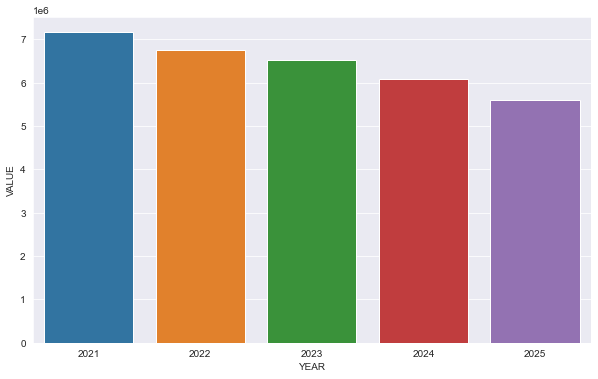

In [22]:
cols = ['COMPANY','PRODUCT','YEAR','GRANULARITY','VALUE']
df = production_forecast[cols] \
        .groupby(['YEAR','GRANULARITY'])['VALUE'].sum() \
        .reset_index()
plt.figure(figsize=(10,6))
sns.barplot(x="YEAR", y="VALUE", data=df)

In [19]:
cols = ['COMPANY','PRODUCT','YEAR','GRANULARITY','VALUE']
df = production_forecast[cols] \
        .groupby(['COMPANY','YEAR','GRANULARITY'])['VALUE'].sum() \
        .reset_index()

<AxesSubplot:xlabel='YEAR', ylabel='VALUE'>

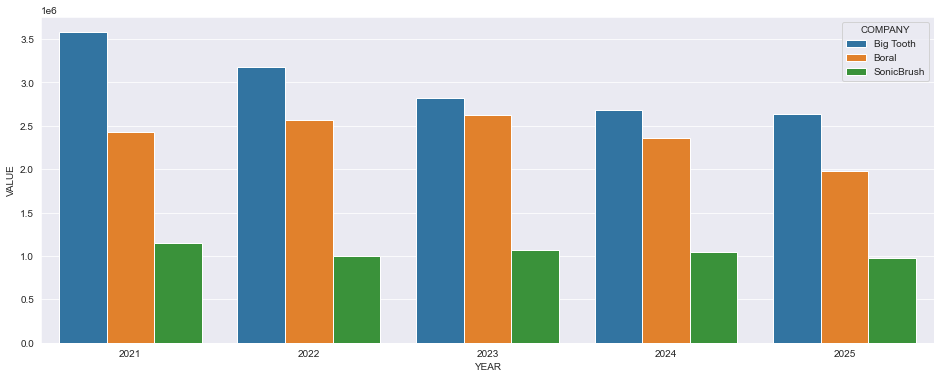

In [20]:
plt.figure(figsize=(16,6))
sns.barplot(x="YEAR", y="VALUE", hue="COMPANY", data=df)

### Part 2. II - Analyse the impact on part suppliers

In [27]:
## Merge product forecast data and part supplier data, and derive forecasted annual sales for each part supplier
production_forecast = file_reader.get_forecast_data()
production_forecast = production_forecast.query("GRANULARITY == 'YEAR'")
parts_supplier = file_reader.parts_supplier
materials_suppliers = file_reader.materials_suppliers
production_forecast['YEAR'] = production_forecast['DATE'].apply(lambda x: x.split('-')[0])

In [28]:
suppliers = parts_supplier.merge(materials_suppliers, left_on=['COMPANY','PART'], right_on=['CUSTOMER','CUSTOMER_PRODUCT'],
                                 suffixes=('_PARTS','_MATERIALS'))
df = production_forecast.merge(suppliers, left_on=['COMPANY','PRODUCT'], right_on=['CUSTOMER_PARTS','CUSTOMER_PRODUCT_PARTS'])
df = df.merge(materials_suppliers, left_on=['COMPANY','PRODUCT'], right_on=['CUSTOMER','CUSTOMER_PRODUCT'],
             suffixes=('','_DIRECT'), how='left')
df.head()

,COMPANY,PRODUCT,DATE,GRANULARITY,VALUE,YEAR,PART_TYPE,COMPANY_PARTS,PART,CUSTOMER_PARTS,CUSTOMER_PRODUCT_PARTS,PRICE_PER_PRODUCT_PARTS,MATERIAL,COMPANY_MATERIALS,CUSTOMER_MATERIALS,CUSTOMER_PRODUCT_MATERIALS,PRICE_PER_PRODUCT_MATERIALS,MATERIAL_DIRECT,COMPANY_DIRECT,CUSTOMER,CUSTOMER_PRODUCT,PRICE_PER_PRODUCT
0,Big Tooth,BT-2000,2021-12-31,YEAR,3.579502e+06,2021,Motor,Emotor,M5498,Big Tooth,BT-2000,4.200,Metal,Matco,Emotor,M5498,2.1000,NaN,NaN,NaN,NaN,NaN
1,Big Tooth,BT-2000,2021-12-31,YEAR,3.579502e+06,2021,Brush,Bristle,B648,Big Tooth,BT-2000,1.575,Plastic,TWP,Bristle,B648,0.7875,NaN,NaN,NaN,NaN,NaN
2,Big Tooth,BT-2000,2021-12-31,YEAR,3.579502e+06,2021,Case,CaseCo,C456,Big Tooth,BT-2000,2.625,Plastic,TWP,CaseCo,C456,1.3125,NaN,NaN,NaN,NaN,NaN
3,Big Tooth,BT-2000,2022-12-31,YEAR,2.722915e+06,2022,Motor,Emotor,M5498,Big Tooth,BT-2000,4.200,Metal,Matco,Emotor,M5498,2.1000,NaN,NaN,NaN,NaN,NaN
4,Big Tooth,BT-2000,2022-12-31,YEAR,2.722915e+06,2022,Brush,Bristle,B648,Big Tooth,BT-2000,1.575,Plastic,TWP,Bristle,B648,0.7875,NaN,NaN,NaN,NaN,NaN


In [29]:
parts_supplier_forecast = parts_supplier.merge(production_forecast, left_on=['CUSTOMER','CUSTOMER_PRODUCT'], right_on=['COMPANY', 'PRODUCT'],
                                     suffixes=('_PARTS',''))
parts_supplier_forecast['SALES'] = parts_supplier_forecast['PRICE_PER_PRODUCT'] * parts_supplier_forecast['VALUE']

In [30]:
parts_supplier_forecast.head()

,PART_TYPE,COMPANY_PARTS,PART,CUSTOMER,CUSTOMER_PRODUCT,PRICE_PER_PRODUCT,COMPANY,PRODUCT,DATE,GRANULARITY,VALUE,YEAR,SALES
0,Motor,Emotor,M5498,Big Tooth,BT-2000,4.2,Big Tooth,BT-2000,2021-12-31,YEAR,3.579502e+06,2021,1.503391e+07
1,Motor,Emotor,M5498,Big Tooth,BT-2000,4.2,Big Tooth,BT-2000,2022-12-31,YEAR,2.722915e+06,2022,1.143624e+07
2,Motor,Emotor,M5498,Big Tooth,BT-2000,4.2,Big Tooth,BT-2000,2023-12-31,YEAR,5.260671e+05,2023,2.209482e+06
3,Motor,Emotor,M5498,Big Tooth,BT-2000,4.2,Big Tooth,BT-2000,2024-12-31,YEAR,0.000000e+00,2024,0.000000e+00
4,Motor,Emotor,M5498,Big Tooth,BT-2000,4.2,Big Tooth,BT-2000,2025-12-31,YEAR,0.000000e+00,2025,0.000000e+00


In [31]:
cols = ['PART_TYPE','COMPANY_PARTS','YEAR','SALES']
df = parts_supplier_forecast[cols] \
        .groupby(['COMPANY_PARTS','YEAR'])['SALES'].sum().reset_index()


#### Overall Sales Prediction of Part Suppliers
- 💡 **Insight**
1. There are 8 main suppliers for 4 different part types
2. Emotor/BAM/CaseCo are the top 3 suppliers as of now; CaseCo are expected to have a cliff drop through the coming 5 years
3. Overall sales of CDBC are expected to be 8-9 times of the current sales. Due to the production boost on product Big Tooth	BT-3000

<AxesSubplot:xlabel='COMPANY_PARTS', ylabel='SALES'>

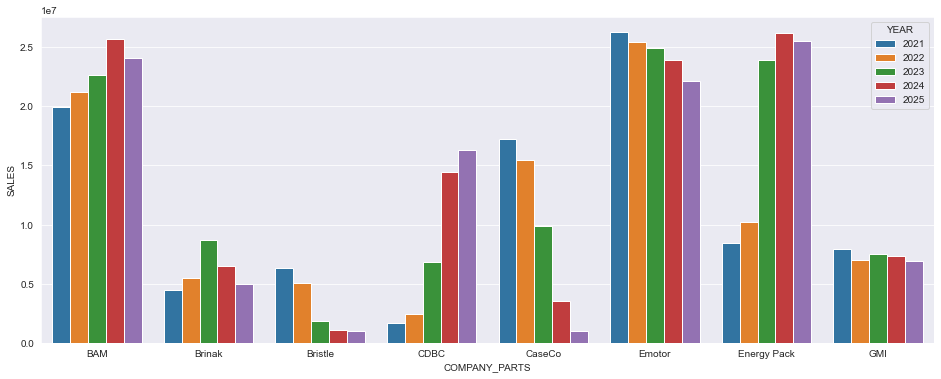

In [32]:
plt.figure(figsize=(16,6))
sns.barplot(x="COMPANY_PARTS", y="SALES", hue="YEAR", data=df)

 #### Sales Prediction of Part Suppliers on different part Types
- 💡 **Insight**
1. Brush/Case/Motor are having stable market share
2. Battery market will have the potention to expand to 2x

In [264]:
cols = ['PART_TYPE','COMPANY_PARTS','YEAR','SALES']
df = parts_supplier_forecast[cols] \
        .groupby(['PART_TYPE','YEAR'])['SALES'].sum().reset_index()

<AxesSubplot:xlabel='PART_TYPE', ylabel='SALES'>

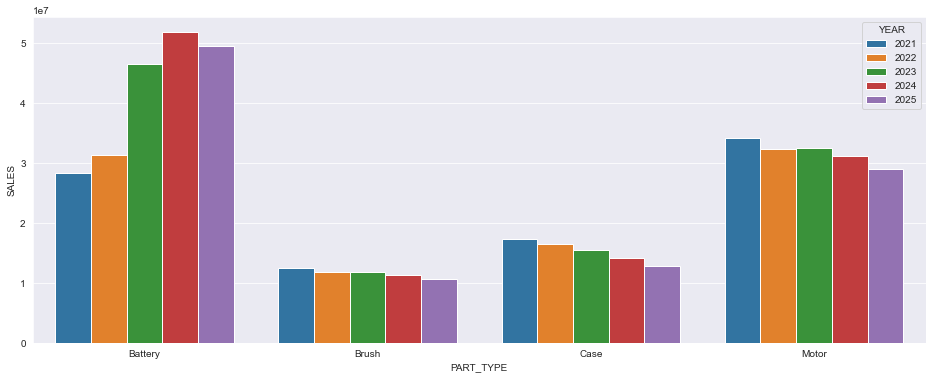

In [265]:
plt.figure(figsize=(16,6))
sns.barplot(x="PART_TYPE", y="SALES", hue="YEAR", data=df)

In [266]:
df['PART_TYPE'].unique()

array(['Battery', 'Brush', 'Case', 'Motor'], dtype=object)

In [223]:
df = parts_supplier_forecast[cols]
battery_df = df[df['PART_TYPE'] == 'Battery']
battery_df = battery_df.groupby(['COMPANY_PARTS','YEAR','GRANULARITY'])['SALES'].sum().reset_index()
brush_df = df[df['PART_TYPE'] == 'Brush']
brush_df = brush_df.groupby(['COMPANY_PARTS','YEAR','GRANULARITY'])['SALES'].sum().reset_index()
case_df = df[df['PART_TYPE'] == 'Case']
case_df = case_df.groupby(['COMPANY_PARTS','YEAR','GRANULARITY'])['SALES'].sum().reset_index()
motor_df = df[df['PART_TYPE'] == 'Motor']
motor_df = motor_df.groupby(['COMPANY_PARTS','YEAR','GRANULARITY'])['SALES'].sum().reset_index()

In [225]:
print(battery_df['COMPANY_PARTS'].unique())
print(brush_df['COMPANY_PARTS'].unique())
print(case_df['COMPANY_PARTS'].unique())
print(motor_df['COMPANY_PARTS'].unique())

['BAM' 'Energy Pack']
['Brinak' 'Bristle' 'CDBC']
['CDBC' 'CaseCo']
['Emotor' 'GMI']


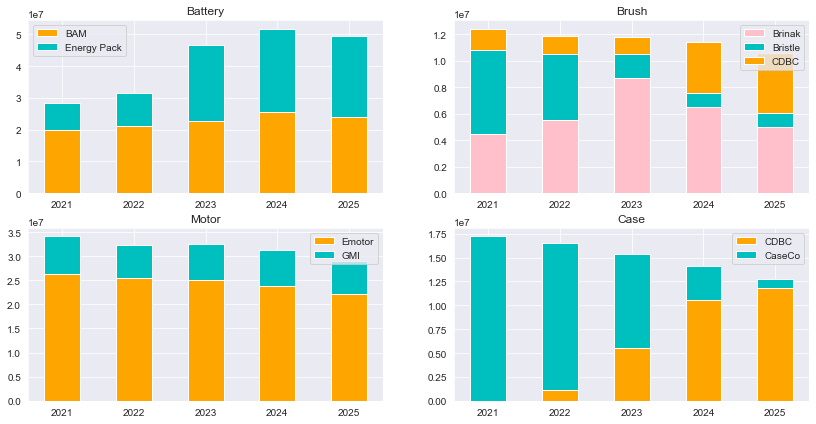

In [238]:
plt.figure(figsize=(14,7))
plt.subplot(221)
BAM = battery_df[battery_df['COMPANY_PARTS']=='BAM'].set_index('YEAR').sort_index()['SALES']
EP = battery_df[battery_df['COMPANY_PARTS']=='Energy Pack'].set_index('YEAR').sort_index()['SALES']
a = 0.5
years=BAM.index.tolist()
plt.bar(years, BAM, a, color = 'orange', label = 'BAM')
plt.bar(years, EP, a, bottom = BAM, color = 'c', label = 'Energy Pack')
plt.title("Battery")
plt.legend()

plt.subplot(222)
Brinak = brush_df[brush_df['COMPANY_PARTS']=='Brinak'].set_index('YEAR').sort_index()['SALES']
Bristle = brush_df[brush_df['COMPANY_PARTS']=='Bristle'].set_index('YEAR').sort_index()['SALES']
CDBC = brush_df[brush_df['COMPANY_PARTS']=='CDBC'].set_index('YEAR').sort_index()['SALES']
a = 0.5
years=Brinak.index.tolist()
plt.bar(years, Brinak, a, color = 'pink', label = 'Brinak')
plt.bar(years, Bristle, a, bottom = Brinak, color = 'c', label = 'Bristle')
plt.bar(years, CDBC, a, bottom = Brinak + Bristle, color = 'orange', label = 'CDBC')
plt.title("Brush")
plt.legend()

plt.subplot(223)
Emotor = motor_df[motor_df['COMPANY_PARTS']=='Emotor'].set_index('YEAR').sort_index()['SALES']
GMI = motor_df[motor_df['COMPANY_PARTS']=='GMI'].set_index('YEAR').sort_index()['SALES']
a = 0.5
years=Emotor.index.tolist()
plt.bar(years, Emotor, a, color = 'orange', label = 'Emotor')
plt.bar(years, GMI, a, bottom = Emotor, color = 'c', label = 'GMI')
plt.title("Motor")
plt.legend()

plt.subplot(224)
CDBC = case_df[case_df['COMPANY_PARTS']=='CDBC'].set_index('YEAR').sort_index()['SALES']
CaseCo = case_df[case_df['COMPANY_PARTS']=='CaseCo'].set_index('YEAR').sort_index()['SALES']
a = 0.5
years=CDBC.index.tolist()
plt.bar(years, CDBC, a, color = 'orange', label = 'CDBC')
plt.bar(years, CaseCo, a, bottom = CDBC, color = 'c', label = 'CaseCo')
plt.title("Case")
plt.legend()



 #### Sales Prediction of Part Suppliers on different part Types
- 💡 **Insight**
1. Battery market expansion will greatly benefit Energy Pack
2. Brush market will be stable, though we are expecting CDBC will become the dominiant of the market
3. CDBC will take more share in Case/Brush in the futrue

### Part 2. II - Material Suppliers Sales
#### Sales Prediction of different Material Suppliers 
- 💡 **Insight**
1. TWP will have a hard drop
2. Chemco, GPoly would be the rising star in five years with revenue boosting

In [267]:
materials_suppliers_forecast = parts_supplier_forecast.merge(materials_suppliers, left_on=['COMPANY_PARTS','PART'], right_on=['CUSTOMER','CUSTOMER_PRODUCT'],
                                 suffixes=('','_MATERIALS'))
## merge GPP - direct supplier for SonicBrush 
materials_suppliers_forecast = materials_suppliers_forecast.merge(materials_suppliers, left_on=['COMPANY','PRODUCT'], right_on=['CUSTOMER','CUSTOMER_PRODUCT'],
             suffixes=('','_DIRECT'), how='left')
materials_suppliers_forecast['PRICE_PER_PRODUCT_DIRECT'].fillna(0, inplace=True)
materials_suppliers_forecast['PRICE_PER_PRODUCT_MATERIAL'] = materials_suppliers_forecast['PRICE_PER_PRODUCT_DIRECT'] \
            + materials_suppliers_forecast['PRICE_PER_PRODUCT']
materials_suppliers_forecast['METERIAL_COMPANY_SALES'] = materials_suppliers_forecast['PRICE_PER_PRODUCT_MATERIAL'] * \
                    materials_suppliers_forecast['VALUE']
cols = ['MATERIAL','COMPANY_MATERIALS','CUSTOMER_PRODUCT_MATERIALS','YEAR', 'METERIAL_COMPANY_SALES']
materials_suppliers_forecast[cols].head()

,MATERIAL,COMPANY_MATERIALS,CUSTOMER_PRODUCT_MATERIALS,YEAR,METERIAL_COMPANY_SALES
0,Metal,Matco,M5498,2021,1.503391e+07
1,Metal,Matco,M5498,2022,1.143624e+07
2,Metal,Matco,M5498,2023,2.209482e+06
3,Metal,Matco,M5498,2024,0.000000e+00
4,Metal,Matco,M5498,2025,0.000000e+00


<AxesSubplot:xlabel='COMPANY_MATERIALS', ylabel='METERIAL_COMPANY_SALES'>

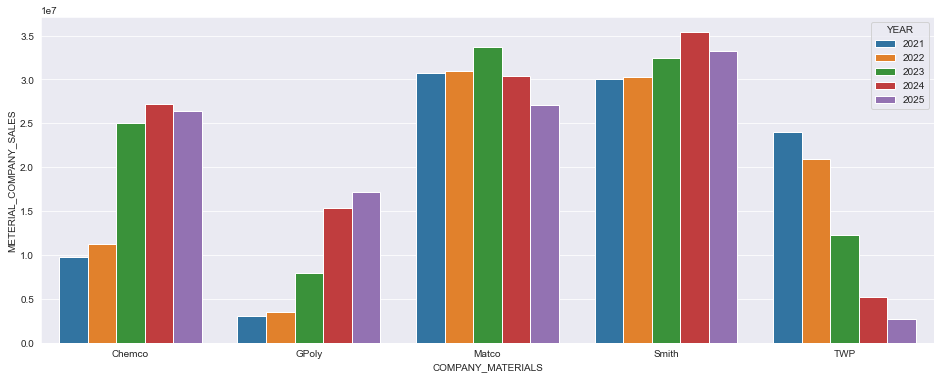

In [268]:
df = materials_suppliers_forecast[cols] \
        .groupby(['COMPANY_MATERIALS','YEAR'])['METERIAL_COMPANY_SALES'].sum().reset_index()
plt.figure(figsize=(16,6))
sns.barplot(x="COMPANY_MATERIALS", y="METERIAL_COMPANY_SALES", hue="YEAR", data=df)

In [269]:
materials_suppliers_forecast['MATERIAL'].unique()


array(['Metal', 'Plastic', 'Lithium'], dtype=object)

In [275]:
df = materials_suppliers_forecast[cols].copy()
Metal = df[df['MATERIAL'] == 'Metal']
Metal = Metal.groupby(['COMPANY_MATERIALS','YEAR'])['METERIAL_COMPANY_SALES'].sum().reset_index()
Plastic = df[df['MATERIAL'] == 'Plastic']
Plastic = Plastic.groupby(['COMPANY_MATERIALS','YEAR'])['METERIAL_COMPANY_SALES'].sum().reset_index()
Lithium = df[df['MATERIAL'] == 'Lithium']
Lithium = Lithium.groupby(['COMPANY_MATERIALS','YEAR'])['METERIAL_COMPANY_SALES'].sum().reset_index()

In [276]:
print(Metal['COMPANY_MATERIALS'].unique())
print(Plastic['COMPANY_MATERIALS'].unique())
print(Lithium['COMPANY_MATERIALS'].unique())

['Matco' 'Smith']
['GPoly' 'Matco' 'TWP']
['Chemco' 'Smith']


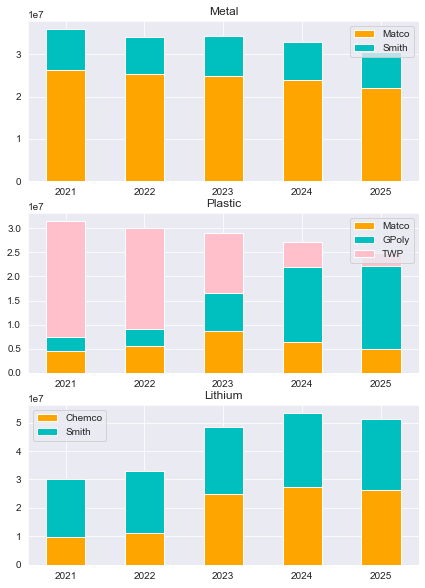

In [279]:
plt.figure(figsize=(7,10))
plt.subplot(311)
Matco = Metal[Metal['COMPANY_MATERIALS']=='Matco'].set_index('YEAR').sort_index()['METERIAL_COMPANY_SALES']
Smith = Metal[Metal['COMPANY_MATERIALS']=='Smith'].set_index('YEAR').sort_index()['METERIAL_COMPANY_SALES']
a = 0.5
years=Matco.index.tolist()
plt.bar(years, Matco, a, color = 'orange', label = 'Matco')
plt.bar(years, Smith, a, bottom = Matco, color = 'c', label = 'Smith')
plt.title("Metal")
plt.legend()

plt.subplot(312)
GPoly = Plastic[Plastic['COMPANY_MATERIALS']=='GPoly'].set_index('YEAR').sort_index()['METERIAL_COMPANY_SALES']
Matco = Plastic[Plastic['COMPANY_MATERIALS']=='Matco'].set_index('YEAR').sort_index()['METERIAL_COMPANY_SALES']
TWP = Plastic[Plastic['COMPANY_MATERIALS']=='TWP'].set_index('YEAR').sort_index()['METERIAL_COMPANY_SALES']
a = 0.5
years=GPoly.index.tolist()
plt.bar(years, Matco, a, color = 'orange', label = 'Matco')
plt.bar(years, GPoly, a, bottom = Matco, color = 'c', label = 'GPoly')
plt.bar(years, TWP, a, bottom = Matco + GPoly, color = 'pink', label = 'TWP')
plt.title("Plastic")
plt.legend()

plt.subplot(313)
Chemco = Lithium[Lithium['COMPANY_MATERIALS']=='Chemco'].set_index('YEAR').sort_index()['METERIAL_COMPANY_SALES']
Smith = Lithium[Lithium['COMPANY_MATERIALS']=='Smith'].set_index('YEAR').sort_index()['METERIAL_COMPANY_SALES']
a = 0.5
years=Chemco.index.tolist()
plt.bar(years, Chemco, a, color = 'orange', label = 'Chemco')
plt.bar(years, Smith, a, bottom = Chemco, color = 'c', label = 'Smith')
plt.title("Lithium")
plt.legend()


### Part 2. II - Material Suppliers Sales
#### Sales Prediction of different Material Suppliers on each material
- 💡 **Insight**
1. Metal will have stable demand
2. Lithium will have greater demand in next five years, due to the battery involvement. Chemco will be benefit from it
3. Plastic will have less demand, TWP will be greatly impacted. However, GPoly are expected to have a good expansion and take up most of market share from TWP


# Conclusion
According to the prediction of next five years of production
1. Part Supplier
* CDBC & Energy Pack will have the largest growth
* Bristile and CaseCo will have largest drop
2. Material Supplier
* Chemco & GPoly will have the largest growth
* TWP will have largest drop